In [1]:
pip install --upgrade yfinance==0.2.54

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.51
    Uninstalling yfinance-0.2.51:
      Successfully uninstalled yfinance-0.2.51
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install arch

SyntaxError: invalid syntax (2360124105.py, line 1)

In [6]:

pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 17.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 13.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install pandas_datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import yfinance as yf
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm  # for CAPM and Fama-French regressions
import pandas_datareader
import matplotlib.pyplot as plt
from arch import arch_model
import itertools

In [20]:
# --- Step 1: Load Fama-French 3-factor data ---
# Adjust the read_csv parameters based on your file format; many FF files have header rows to skip.
ff = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', skiprows=4, header=0, names=['Date','Mkt-RF','SMB','HML','RF']) # Added names and header, skiprows to 4
# If the date is in yyyymmdd format, convert it:
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m%d')

# Filter for the desired date range
start = '2020-01-01'
end = '2023-12-31'
ff = ff[(ff['Date'] >= start) & (ff['Date'] <= end)]

# Set the date as index and ensure the numeric columns are floats.
ff.set_index('Date', inplace=True)
# Convert factor returns from percentages (if necessary)
ff = ff.astype(float) / 100

# --- Step 2: Download stock returns for AAPL and GOOG ---
tickers = ['AAPL', 'GOOG']
prices = yf.download(tickers, start=start, end=end)['Close']

# Calculate daily returns
returns = prices.pct_change().dropna()

# --- Step 3: Align the data ---
# Keep only dates that appear in both datasets
common_dates = returns.index.intersection(ff.index)
returns = returns.loc[common_dates]
ff = ff.loc[common_dates]

# --- Step 4: Run the regression for each ticker ---
results = {}
for ticker in tickers:
    # Create a DataFrame that includes the stock’s daily return and the FF factors
    df = pd.DataFrame({'r': returns[ticker]})
    df = df.join(ff[['Mkt-RF', 'SMB', 'HML', 'RF']])

    # Compute excess returns: r_it - RF
    df['excess'] = df['r'] - df['RF']

    # Define independent variables: factors (add constant for intercept)
    X = df[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)

    # Dependent variable: excess return
    y = df['excess']

    # Run the OLS regression
    model = sm.OLS(y, X).fit()
    results[ticker] = model

    print(f"\nRegression results for {ticker}:")
    print(model.summary())


[*********************100%***********************]  2 of 2 completed


Regression results for AAPL:
                            OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     882.4
Date:                Mon, 24 Feb 2025   Prob (F-statistic):          1.67e-280
Time:                        14:00:02   Log-Likelihood:                 3099.8
No. Observations:                1005   AIC:                            -6192.
Df Residuals:                    1001   BIC:                            -6172.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006 

In [ ]:
# --- Step 1: Load and Prepare the Data ---
# Read in the Fama–French 3-factor CSV file (adjust skiprows if needed)
ff = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', skiprows=4, header=0, names=['Date','Mkt-RF','SMB','HML','RF']) # Added names and header, skiprows to 4
# If the date is in yyyymmdd format, convert it:
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m%d')
ff = ff.set_index('Date')
# Convert factor returns from percentages to decimals
ff = ff.astype(float) / 100

# Use data up to (and including) the end date 2023-12-31
ff = ff.loc[ff.index <= '2023-12-31']

# --- Step 2: Forecast Setup ---
# Forecast horizon for the next day
horizon = 1

# Dictionary to store forecast results for each factor
forecast_results = {}

# --- Step 3: Fit a GARCH(1,1) Model and Forecast for the Next Day ---
for factor in ['Mkt-RF', 'SMB', 'HML']:
    series = ff[factor].dropna()

    # Fit a GARCH(1,1) model with a constant mean
    am = arch_model(100*series, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
    res = am.fit(disp='off')

    # Forecast for the next day
    forecast = res.forecast(horizon=horizon, reindex=False)

    # Extract the forecasted mean and variance for the next day.
    # We use .iloc[-1] to take forecasts made at the last available date.
    next_day_mean = forecast.mean.iloc[-1, 0]
    next_day_variance = forecast.variance.iloc[-1, 0]

    forecast_results[factor] = {'next_day_mean': next_day_mean, 'next_day_variance': next_day_variance}

    print(f"Forecast for {factor} (next day):")
    print(f"Mean forecast: {next_day_mean}")
    print(f"Variance forecast: {next_day_variance}\n")


ValueError: NaN or inf values found in y. y must contains only finite values.

In [13]:
# Example: previously estimated coefficients for AAPL and GOOG
coeffs = {
    "AAPL": {
        "alpha": 0.0006,
        "Mkt-RF": 1.1878,
        "SMB": -0.3965,
        "HML": -0.3792,
    },
    "GOOG": {
        "alpha": 0.0004,
        "Mkt-RF": 1.1080,
        "SMB": -0.2677,
        "HML": -0.3556,
    }
}

# Assume forecast_results is a dictionary with the following structure:
# forecast_results = {
#    'Mkt-RF': {'next_day_mean': forecasted_mean_MktRF},
#    'SMB':    {'next_day_mean': forecasted_mean_SMB},
#    'HML':    {'next_day_mean': forecasted_mean_HML}
# }
# Remember, these forecasts are on a 100× scale so we need to divide by 100
# to bring them back to the same units as used in the regression.

# Calculate next day forecasted returns for each stock using:
# r_{i,t+1} = alpha_i + beta_{i,Mkt} * (forecast_Mkt-RF/100) + beta_{i,SMB} * (forecast_SMB/100) + beta_{i,HML} * (forecast_HML/100)
forecast_r = {}
for ticker in coeffs:
    alpha = coeffs[ticker]["alpha"]
    r_forecast = (
        alpha +
        coeffs[ticker]["Mkt-RF"] * (forecast_results["Mkt-RF"]["next_day_mean"] / 100) +
        coeffs[ticker]["SMB"] * (forecast_results["SMB"]["next_day_mean"] / 100) +
        coeffs[ticker]["HML"] * (forecast_results["HML"]["next_day_mean"] / 100)
    )
    forecast_r[ticker] = r_forecast
    print(f"Forecasted r_{ticker}, t+1: {r_forecast}")


Forecasted r_AAPL, t+1: 0.001214260420211767
Forecasted r_GOOG, t+1: 0.0009774111346415666


In [14]:
# Assume you already have:
# - coeffs: a dictionary with regression estimates for each stock
# - results: a dictionary with the regression model results for each stock (e.g., from statsmodels)
# - forecast_results: a dictionary with GARCH one-day forecast for each factor on the 100x scale.
#
# Example coefficients for AAPL and GOOG:
coeffs = {
    "AAPL": {
        "alpha": 0.0006,
        "Mkt-RF": 1.1878,
        "SMB": -0.3965,
        "HML": -0.3792,
    },
    "GOOG": {
        "alpha": 0.0004,
        "Mkt-RF": 1.1080,
        "SMB": -0.2677,
        "HML": -0.3556,
    }
}

# List of factor names
factors = ['Mkt-RF', 'SMB', 'HML']

# Dictionary to store total forecast error variance for each stock
total_forecast_error = {}

# Loop over each stock
for ticker in coeffs:
    beta_squared_term = 0
    for factor in factors:
        beta = coeffs[ticker][factor]
        # forecast_results[factor]["next_day_variance"] is on a 100x scale,
        # so convert it to the original scale:
        factor_variance = forecast_results[factor]["next_day_variance"] / (100**2)
        beta_squared_term += (beta**2) * factor_variance
    # Regression residual variance for this stock, using the mean squared error of residuals
    sigma2_reg = results[ticker].mse_resid
    total_var = beta_squared_term + sigma2_reg
    total_forecast_error[ticker] = total_var
    print(f"Total forecast error variance for {ticker}: {total_var}")


Total forecast error variance for AAPL: 0.00020974911830318562
Total forecast error variance for GOOG: 0.0002313160362368219


In [2]:
def garch_aic_sel(returns):
    # Define grids for model parameters
    mean_models = ['Constant', 'AR']
    vol_models = ['GARCH', 'EGARCH']
    dists = ['normal', 't']

    results = []

    for mean in mean_models:
        for vol in vol_models:
            for dist in dists:
                lags = 1 if mean == 'AR' else 0
                
                # -----------------------------
                # Fit the full model on the complete dataset
                model = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res = model.fit(disp='off')

                # -----------------------------
                # Get the AIC from the model
                aic = res.aic
                results.append({'mean': mean, 'vol': vol, 'dist': dist, 'aic': aic})

    # Find the best model based on AIC
    results_df = pd.DataFrame(results)
    best_model = results_df.loc[results_df['aic'].idxmin()]
    return best_model['mean'], best_model['vol'], best_model['dist']

In [11]:
#Combined Code

# ----------------------------
# 1. Load Fama–French Factor Data
# ----------------------------
ff = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=4, header=0, names=['Date','Mkt-RF','SMB','HML','RF']) # Added names and header, skiprows to 4
# If the date is in yyyymmdd format, convert it:
ff['Date'] = pd.to_datetime(ff['Date'], format='%Y%m')
ff = ff.set_index('Date')
# Convert factor returns from percentages to decimals
ff = ff.astype(float) / 100
# Use data up to and including 2024-12-31
#ff = ff.loc[ff.index <= '2024-12-31' & ff.index >= '2009-12-31']

#ff.index = ff.index.shift(1, freq='ME')

# ----------------------------
# 2. Forecast Factors using GARCH(1,1) on 100x Scaled Data
# ----------------------------
forecast_results = {}
factors = ['Mkt-RF', 'SMB', 'HML']

for factor in factors:
    series_ = ff[factor].dropna()
    # convert to log-returns
    series = np.log(1 + series_)
    # Scale the series by 100 to stabilize the GARCH estimation
    mean, vol, dist = garch_aic_sel(100 * series)
    am = arch_model(100 * series, mean=mean, vol=vol, p=1, q=1, dist=dist)
    res = am.fit(disp='off')

    # Forecast one day ahead (next day)
    forecast = res.forecast(horizon=1, reindex=False)

    # The forecasted mean is on a 100x scale and variance on a 100^2 scale.
    next_day_mean_ = forecast.mean.iloc[-1, 0]
    next_day_variance_ = forecast.variance.iloc[-1, 0]

    # covert to simple returns
    next_day_mean = (np.exp(next_day_mean_ / 100) - 1)
    next_day_variance = (np.exp(next_day_variance_ / 100**2) - 1)

    forecast_results[factor] = {'next_day_mean': next_day_mean,
                                'next_day_variance': next_day_variance}
    print(f"Forecast for {factor} (next period): Mean = {next_day_mean}, Variance = {next_day_variance}")

# ----------------------------
# 3. Download Stock Data and Run Regressions
# ----------------------------
tickers = ["AAPL", "MSFT", "GOOG", "BRK-B", "JPM", "JNJ", "V", "PG"]
prices = yf.download(tickers, start='2009-12-31', end='2024-12-31', interval='1mo', auto_adjust=True)['Close']

#prices.index = prices.index.shift(-1, freq='D')
returns = prices.pct_change().dropna()

# Align dates of stock returns and factor data
common_dates = returns.index.intersection(ff.index)
returns = returns.loc[common_dates]
ff = ff.loc[common_dates]

# Run OLS regressions to estimate factor loadings and obtain residual variances.
results = {}   # to store regression outputs
coeffs = {}    # to store estimated coefficients for each ticker

for ticker in tickers:
    df = pd.DataFrame({'r': returns[ticker]})
    df = df.join(ff[['Mkt-RF', 'SMB', 'HML', 'RF']])
    # Compute excess returns: r - RF
    df['excess'] = df['r'] - df['RF']

    # Independent variables are the three factors (with constant)
    X = df[['Mkt-RF', 'SMB', 'HML']]
    X = sm.add_constant(X)
    y = df['excess']

    model = sm.OLS(y, X).fit()
    results[ticker] = model
    coeffs[ticker] = {
         'alpha': model.params['const'],
         'Mkt-RF': model.params['Mkt-RF'],
         'SMB': model.params['SMB'],
         'HML': model.params['HML']
    }

    print(f"\nRegression results for {ticker}:\n", model.summary())

# ----------------------------
# 4. Forecast Next Day Expected Returns (r_{i,t+1})
# ----------------------------
forecast_r = {}
for ticker in tickers:
    # r_{i,t+1} = alpha_i + beta_i,Mkt * (forecast_Mkt/100) + beta_i,SMB * (forecast_SMB/100) + beta_i,HML * (forecast_HML/100)
    alpha = coeffs[ticker]['alpha']
    r_forecast = alpha
    for factor in factors:
        beta = coeffs[ticker][factor]
        # Convert forecasted factor mean from 100x scale back to original scale by dividing by 100.
        factor_mean = forecast_results[factor]['next_day_mean'] / 100
        r_forecast += beta * factor_mean
    forecast_r[ticker] = r_forecast
    print(f"\nForecasted r_{ticker}, t+1: {r_forecast}")

# ----------------------------
# 5. Calculate Total Forecast Error Variance for r_{i,t+1}
# ----------------------------
# Total variance = sum_j (beta_{ij}^2 * (sigma_{j, forecast}^2 / 100^2)) + sigma^2_reg,
# where sigma^2_reg is the mean squared error (residual variance) from the regression.
forecast_error = {}
for ticker in tickers:
    beta_squared_sum = 0
    for factor in factors:
        beta = coeffs[ticker][factor]
        # Convert forecasted variance from 100x scale back to original scale: divide by 100^2.
        factor_variance = forecast_results[factor]['next_day_variance'] / (100**2)
        beta_squared_sum += (beta**2) * factor_variance

    sigma2_reg = results[ticker].mse_resid  # regression residual variance
    total_variance = beta_squared_sum + sigma2_reg
    forecast_error[ticker] = total_variance
    print(f"Total forecast error variance for {ticker}: {total_variance}")


Forecast for Mkt-RF (next period): Mean = 0.009348032713710985, Variance = 0.0016174797596937296
Forecast for SMB (next period): Mean = 0.000100729865492033, Variance = 0.0011715711160602549


[*********************100%***********************]  8 of 8 completed

Forecast for HML (next period): Mean = 0.0019801727210044806, Variance = 0.0008307418832074198

Regression results for AAPL:
                             OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     44.68
Date:                Mon, 24 Feb 2025   Prob (F-statistic):           1.73e-21
Time:                        17:01:25   Log-Likelihood:                 256.44
No. Observations:                 179   AIC:                            -504.9
Df Residuals:                     175   BIC:                            -492.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

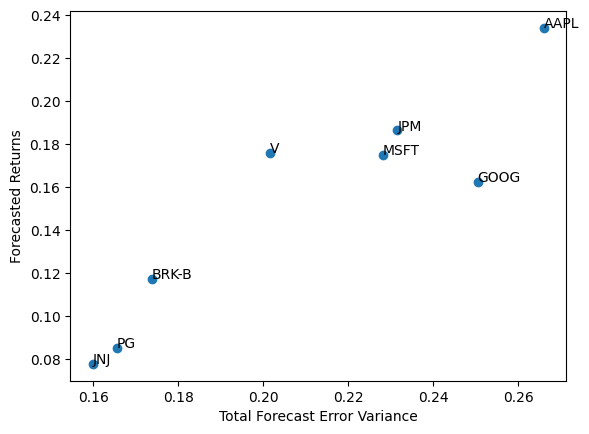

In [42]:
annualizer = 12

annualized_return = {ticker: forecast_r[ticker] * annualizer for ticker in tickers}
annualized_volatility = {ticker: np.sqrt(forecast_error[ticker]) * np.sqrt(annualizer) for ticker in tickers}

plt.scatter(annualized_volatility.values(), annualized_return.values())
# use ticker to label scatter plots
for ticker in tickers:
    plt.text(annualized_volatility[ticker], annualized_return[ticker], ticker)
plt.xlabel('Total Forecast Error Variance')
plt.ylabel('Forecasted Returns')
plt.show()

In [51]:
prices.index.shift(-1, freq='D')

DatetimeIndex(['2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31',
               '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30',
               ...
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30'],
              dtype='datetime64[ns]', name='Date', length=180, freq=None)

In [53]:
ff.index.shift(1, freq='ME')

DatetimeIndex(['2010-02-28', '2010-03-31', '2010-04-30', '2010-05-31',
               '2010-06-30', '2010-07-31', '2010-08-31', '2010-09-30',
               '2010-10-31', '2010-11-30',
               ...
               '2024-03-31', '2024-04-30', '2024-05-31', '2024-06-30',
               '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31',
               '2024-11-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=179, freq=None)

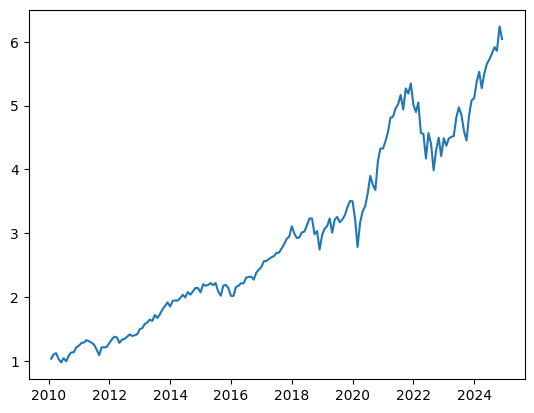

In [47]:
plt.plot(ff.index, np.cumprod(1+ff['Mkt-RF']), label='Mkt-RF')